# **LENGUA DE SEÑAS COLOMBIANA**

***UNIVERSIDAD NACIONAL DE COLOMBIA***

***Diplomado en Inteligencia Artificial y Aprendizaje Profundo***


*Uribe Sandoval Carmen Constanza*

*Marin Peña Dibier*



# LIBRERÍAS

In [ ]:
from google.colab import drive, files
import os
from shutil import copyfile,  rmtree
import zipfile
import random

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import numpy as np

# DATOS

## Creación del directorio del proyecto en Google Drive

In [ ]:
drive.mount('/content/gdrive') # Conecta con Google Drive

Mounted at /content/gdrive


In [ ]:
# Dirección del directorio del proyecto

raiz = '/content/gdrive/MyDrive/Colab Notebooks/senas' 

In [ ]:
# Creación del directorio

try:
  os.mkdir(raiz)
  print('El directorio raiz fue creado')
except:
  print('El directorio raiz ya existe')

try:
  os.mkdir(raiz+'/imgs')
  print('imgs fue creado')
except:
  print('imgs ya existe')

El directorio raiz fue creado
imgs fue creado


## Descarga del conjunto de datos desde Kaggle

El conjunto de datos se descarga desde la dirección [dataset-lsc-modelo](https://www.kaggle.com/oscarstep/dataset-lsc-modelo). Para su descarga es necesario tener una cuenta Kaggle y generar un token de habilitación.

In [ ]:
!pip install -U -q kaggle # Instala la API de Kaggle
!mkdir -p ~/.kaggle
files.upload() # Sube el Token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dibiermarn","key":"17b7c9754028524db14e3a79b9f3295d"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/ # Copia el Token en la caprteta de Kaggle

In [ ]:
# Descarga los datos desde Kaggle en la carpeta /content

!kaggle datasets download -d oscarstep/dataset-lsc-modelo

 64% 25.0M/39.2M [00:00<00:00, 58.8MB/s]
100% 39.2M/39.2M [00:00<00:00, 87.8MB/s]


In [ ]:
# Copia los datos en el directorio raiz

copyfile('/content/dataset-lsc-modelo.zip', raiz+'/senas.zip')

'/content/gdrive/MyDrive/Colab Notebooks/senas/senas.zip'

## Descompresión de los archivos

In [ ]:
zip_ref = zipfile.ZipFile(raiz+'/senas.zip', 'r')
zip_ref.extractall(raiz+'/imgs')
zip_ref.close()

In [ ]:
labels = os.listdir(raiz+'/imgs')
labels.sort()
print(labels)
len(labels)

['a', 'b', 'c', 'd', 'e', 'f', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'w', 'x', 'y']


21

Algunas señas de letras requieren de movimiento para ser representadas como es el caso de la j (es una i con moviendo el meñique en u)

[Abecedario Lengua de Señas Colombiana LSC - Felipe Betancur](https://www.youtube.com/watch?v=JMraBJsA9oI)








In [ ]:
for x in labels: # Cuenta el número de imágenes para cada letra
    print(x +' tiene ', len(os.listdir(raiz+'/imgs/'+x)), ' imágenes.')

a tiene  200  imágenes.
b tiene  200  imágenes.
c tiene  200  imágenes.
d tiene  200  imágenes.
e tiene  200  imágenes.
f tiene  200  imágenes.
i tiene  200  imágenes.
k tiene  200  imágenes.
l tiene  200  imágenes.
m tiene  200  imágenes.
n tiene  200  imágenes.
o tiene  200  imágenes.
p tiene  200  imágenes.
q tiene  200  imágenes.
r tiene  200  imágenes.
t tiene  200  imágenes.
u tiene  200  imágenes.
v tiene  200  imágenes.
w tiene  200  imágenes.
x tiene  200  imágenes.
y tiene  200  imágenes.


## División del los datos

Se creará una división en el conjunto de datos donde el directorio de entrenamiento tendrá el $60\%$ de las imágenes y las restantes se dividirán en directorios de validación y testeo cada uno con el $20\%$ de las imágenes. El conjunto de validación será usado para probar y ajustar el diseño de los modelos mientras que el de testeo sólo será para probar los datos.

In [ ]:
# Creación de las carpetas train y val con las categorías
os.mkdir(raiz+'/split')
os.mkdir(raiz+'/split/train')
os.mkdir(raiz+'/split/val')
os.mkdir(raiz+'/split/test')

for x in labels:
    os.mkdir(raiz+'/split/train/'+x)
    os.mkdir(raiz+'/split/val/'+x)
    os.mkdir(raiz+'/split/test/'+x)

In [ ]:
# Función split para dividir los datos en las carpetas train y val

def splitdir(_dir, _train, _val, _test,  size=0.6): # size está entre 0 y 1
   
    files = os.listdir(_dir)

    u = len(files)    
    v = int(u*size)
    w = v+int((u-v)/2)

    shuffled = random.sample(files, u) # Desorganiza las files
    trainfiles = shuffled[:v]
    valfiles = shuffled[v:w]
    testfiles = shuffled[w:]
    
    for f in trainfiles:
        copyfile(_dir+'/'+f, _train+'/'+f)
        
    for f in valfiles:
        copyfile(_dir+'/'+f, _val+'/'+f)

    for f in testfiles:
        copyfile(_dir+'/'+f, _test+'/'+f)

In [ ]:
# Aplicación de la función anterior

for x in labels:
    splitdir(raiz+'/imgs/'+x,
          raiz+'/split/train/'+x,
          raiz+'/split/val/'+x,
          raiz+'/split/test/'+x)

No es recomendable remover split para el entrenamiento de los modelos. En caso de ser necesario, esta opción lo permite.

In [ ]:
# Remueve el directorio split

eliminar = input('Eliminar el directorio split (y/N) : ').lower()
if eliminar == 'y':
  try:
      rmtree(raiz+'/split')
      print('split removido')
  except:
      print('split no ha sido creado o fue removido')
else:
  print('split no fue removido')

Eliminar el directorio split (y/N) : N
split no fue removido


## Generadores de imágenes

In [ ]:
# Algunas constantes más

esc = 1./225 # Escala de las imágenes
dim = (100,100,3) # Dimensiones de la imagen




Se define una función para construir los generadores de imágenes para los conjuntos de entrenamiento, validación y testeo. Esta función recibe un diccionario con los parámetros de ajuste.

In [ ]:
def img_gen(_dic):

  datagen = ImageDataGenerator(rescale=_dic['sc'],
                               rotation_range=_dic['r'],
                               width_shift_range=_dic['w'],
                               height_shift_range=_dic['h'],
                               shear_range=_dic['sh'],
                               zoom_range=_dic['z'])

  generator = datagen.flow_from_directory(_dic['dir'],
                                          batch_size=50,
                                          class_mode='categorical',
                                          shuffle = _dic['shf'],
                                          #color_mode="grayscale",
                                          target_size=_dic['dim'])
  return generator


A continuación se crea un diccionario con tres diccionarios correspondientes a los parámetros de cada conjunto de imágenes.

In [ ]:
pc = 'sc, dim, dir'.split(', ') # Parámetros constantes
pv= 'r, w, h, sh, z, shf'.split(', ') # Parámetros variables
dirs = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/senas/split')
dirs.sort()
print(dirs)

['test', 'train', 'val']


In [ ]:
# Diccionario listas de parámetros variables r, w, h, sh, z, shf

dp = dict(zip(dirs, [[.0, .0, .0, .0, .0, False], # train
                     [10, .1, .1, .2, .2, True], # val
                     [10, .1, .1, .2, .2, True]])) # test

# Creación de diccionario

dic = {}
for x in dirs:
  dic[x] = dict(zip(pc, [esc, dim[:2], raiz+'/split/'+x]))
  dic[x].update(dict(zip(pv,dp[x])))

print(dic)

{'test': {'sc': 0.0044444444444444444, 'dim': (100, 100), 'dir': '/content/gdrive/MyDrive/Colab Notebooks/senas/split/test', 'r': 0.0, 'w': 0.0, 'h': 0.0, 'sh': 0.0, 'z': 0.0, 'shf': False}, 'train': {'sc': 0.0044444444444444444, 'dim': (100, 100), 'dir': '/content/gdrive/MyDrive/Colab Notebooks/senas/split/train', 'r': 10, 'w': 0.1, 'h': 0.1, 'sh': 0.2, 'z': 0.2, 'shf': True}, 'val': {'sc': 0.0044444444444444444, 'dim': (100, 100), 'dir': '/content/gdrive/MyDrive/Colab Notebooks/senas/split/val', 'r': 10, 'w': 0.1, 'h': 0.1, 'sh': 0.2, 'z': 0.2, 'shf': True}}


Creamos un diccionario con los tres generadores.



In [ ]:
igen = {}
for x in dirs:
  igen[x] = img_gen(dic[x]) 

Found 840 images belonging to 21 classes.
Found 2520 images belonging to 21 classes.
Found 840 images belonging to 21 classes.


# FUNCIONES DE MODELO

En esta sección definiremos un conjunto de funciones comúnes para el entrenamiento y validación de los modelos que vamos a implementar.

## Curvas de aprendizaje

Esta plotea las gráficas de la alimentación del modelo en los conjuntos de entrenamiento y validación.

In [ ]:

def ifit(h): # Recibe el history de entrenamiento
  acc=h.history['accuracy']
  vacc=h.history['val_accuracy']
  loss=h.history['loss']
  vloss=h.history['val_loss']
  epochs=range(len(acc)) # Número de épocas

  # Grápica de Accuracy

  plt.plot(epochs, acc, 'g', "Training Accuracy")
  plt.plot(epochs, vacc, 'b', "Validation Accuracy")
  plt.title('Training and validation accuracy')
  plt.show()

  # Plot training and validation loss per epoch

  plt.plot(epochs, loss, 'g', "Training Loss")
  plt.plot(epochs, vloss, 'b', "Validation Loss")
  plt.title('Training an validation loss')
  plt.show()


## Matriz de Confusión

Esta función recibe un generador de imágenes y un modelo,  grafica la matriz de confusión.

In [ ]:
def cmx(gen, model):

  gen.shuffle = False # Desactiva el barajado aleatorio

  # Vectores de clasificación

  y_pred = model.predict(gen)
  y_pred = np.argmax(y_pred, axis = 1)
  y_true = gen.classes

  labels = (gen.class_indices)
  labels = dict((v,k) for k,v in labels.items()) # Diccionario de clases

  cm = confusion_matrix(y_true, y_pred)

  # Generar figura
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) # Revisar para cambiar el tamaño de la fuente
  ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title='Matriz de confusión',
           ylabel='Categoría real',
           xlabel='Predicción')

  # Rotar y alinear ticks
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

  # Rellenar gráfica con los valores de la matriz de confusión
  fmt = 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  plt.show()

## Pruebas caseras

Esta función al implementarla permite cargar imágenes desde el computador local para verificar los modelos entrenados.

In [ ]:

def casa(model, _dim, _esc, _labels):

  uploaded = files.upload()
  
  for x in uploaded.keys():  
    path = '/content/' + x
    img = image.load_img(path, grayscale = False, target_size=_dim)  
    print('\n','\n', x)
    plt.imshow(img)
    plt.show()
    img  = image.img_to_array(img)*_esc
    img = np.expand_dims(img, axis=0)
    classes = model.predict(img, batch_size=10)
    y = np.argmax(classes)
    print(labels[y], '\n', '\n')

# MODELO 1

## Construcción

Se construye la arquitectura del modelo.

In [ ]:
inputs = tf.keras.Input(shape=dim)
x = layers.Conv2D(16, (3,3), activation='relu', input_shape=dim)(inputs) 
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(32, (4, 4), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(64, (4, 4), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(128, (4,4), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(len(labels), activation='softmax')(x)

model1 = Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Aternativamente damos la opción de cargar un modelo previamente entrenado.

In [ ]:
cargar = input('Cargar modelo previamente entrenado (y/N) : ').lower()

if cargar == 'y':
  model1=tf.keras.models.load_model(raiz+'/senas1.h5')
  print('Se ha cargado senas1.')
else:
  print('No se ha cargado senas 1')

## Resumen

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0     

## Diagrama

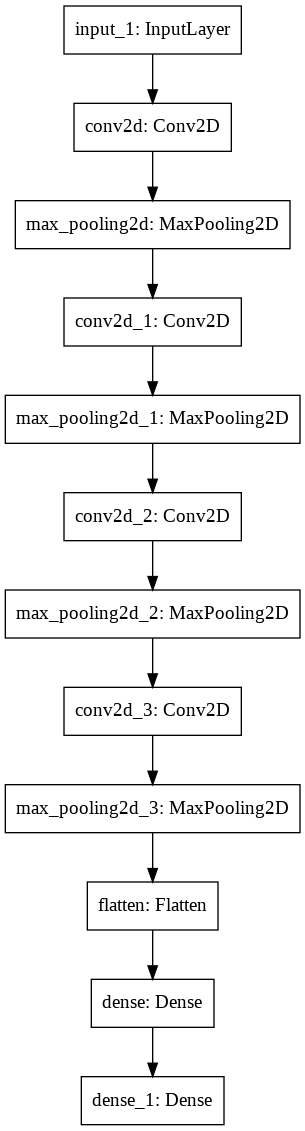

In [ ]:
tf.keras.utils.plot_model(
    model1,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Entrenamiento

In [ ]:
h1 = model1.fit(igen['train'],
                epochs=100,
                verbose=1,
                validation_data=igen['val'])

Epoch 1/100
51/51 [==============================] - 930s 18s/step - loss: 3.0265 - accuracy: 0.0654 - val_loss: 2.7265 - val_accuracy: 0.1429
Epoch 2/100
51/51 [==============================] - 16s 315ms/step - loss: 2.6405 - accuracy: 0.1855 - val_loss: 2.5789 - val_accuracy: 0.1881
Epoch 3/100
51/51 [==============================] - 16s 313ms/step - loss: 2.3751 - accuracy: 0.2467 - val_loss: 2.2644 - val_accuracy: 0.3131
Epoch 4/100
51/51 [==============================] - 16s 317ms/step - loss: 2.1692 - accuracy: 0.3074 - val_loss: 2.1566 - val_accuracy: 0.3060
Epoch 5/100
51/51 [==============================] - 16s 313ms/step - loss: 1.9851 - accuracy: 0.3517 - val_loss: 1.9267 - val_accuracy: 0.3774
Epoch 6/100
51/51 [==============================] - 16s 315ms/step - loss: 1.7766 - accuracy: 0.4099 - val_loss: 1.9039 - val_accuracy: 0.3940
Epoch 7/100
51/51 [==============================] - 16s 310ms/step - loss: 1.6399 - accuracy: 0.4588 - val_loss: 1.8456 - val_accuracy: 

In [ ]:
model1.save(raiz+'/senas1.h5')

## Testeo

In [ ]:
model1.evaluate(igen['test'])

17/17 [==============================] - 3s 147ms/step - loss: 0.6897 - accuracy: 0.8750


[0.6896932721138, 0.875]

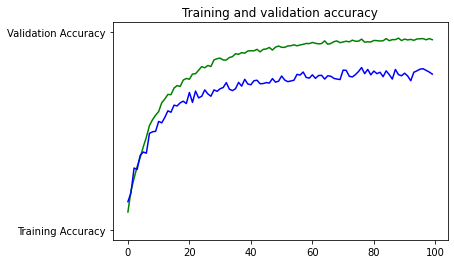

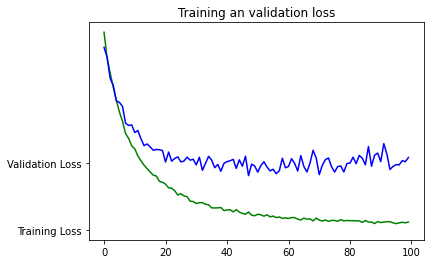

In [ ]:
ifit(h1)

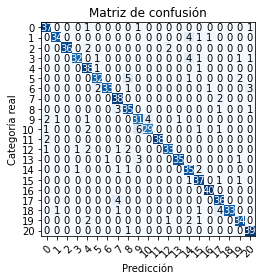

In [ ]:
cmx(igen['test'], model1)

## Casa

Saving r1.jpg to r1 (1).jpg
Saving l1.jpg to l1 (1).jpg
Saving k2.jpg to k2 (1).jpg
Saving k1.png to k1 (1).png
Saving c1.jpg to c1 (1).jpg
Saving b1.jpg to b1 (1).jpg
Saving a3.jpg to a3 (1).jpg
Saving a2.jpg to a2 (1).jpg
Saving a1.jpg to a1 (1).jpg

 
 r1.jpg


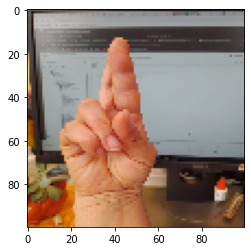

e 
 


 
 l1.jpg


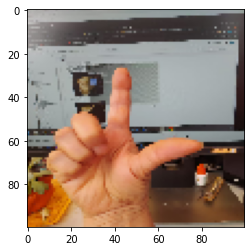

y 
 


 
 k2.jpg


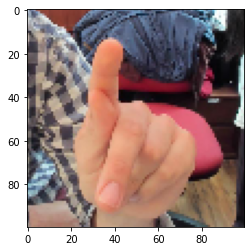

e 
 


 
 k1.png


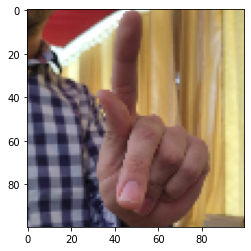

a 
 


 
 c1.jpg


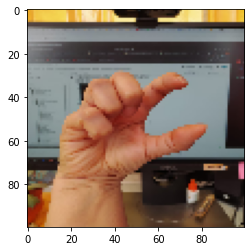

y 
 


 
 b1.jpg


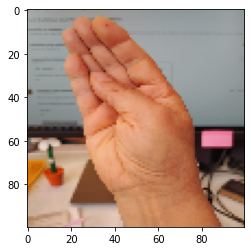

e 
 


 
 a3.jpg


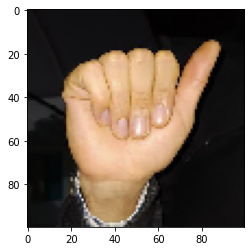

i 
 


 
 a2.jpg


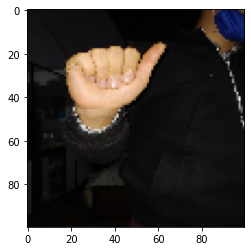

r 
 


 
 a1.jpg


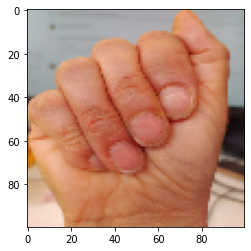

a 
 



In [ ]:
casa(model1, dim[:2], esc, labels)

# INCEPTION V3

In [ ]:
!wget --no-check-certificate \
    'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' \
    -O '/content/gdrive/MyDrive/Colab Notebooks/senas/inception_v3.h5'

--2021-05-23 06:37:37--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/gdrive/MyDrive/Colab Notebooks/senas/inception_v3.h5’

/content/gdrive/MyD 100%[===================>]  83.84M  66.6MB/s    in 1.3s    

2021-05-23 06:37:39 (66.6 MB/s) - ‘/content/gdrive/MyDrive/Colab Notebooks/senas/inception_v3.h5’ saved [87910968/87910968]



In [ ]:


iv3model = InceptionV3(input_shape = dim,
                       include_top = False, 
                       weights = None)

iv3model.load_weights(raiz+'/inception_v3.h5')

for layer in iv3model.layers:
    layer.trainable = False # Esto es para que no se pueda entrenar las capas del modelo preentrenado

In [ ]:

last_layer = iv3model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 768)


# MODELO 2

## Construcción

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)          
outputs = layers.Dense(len(labels), activation='softmax')(x)           

model2 = Model(iv3model.input, outputs) # https://keras.io/api/models/model/
model2.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
cargar = input('Cargar modelo previamente entrenado (y/N) : ').lower()

if cargar == 'y':
  model2=tf.keras.models.load_model(raiz+'/senas2.h5')
  print('Se ha cargado senas2.')
else:
  print('No se ha cargado senas2.')

Cargar modelo previamente entrenado (y/N) : N
No se ha cargado senas2.


## Resumen

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

## Diagrama

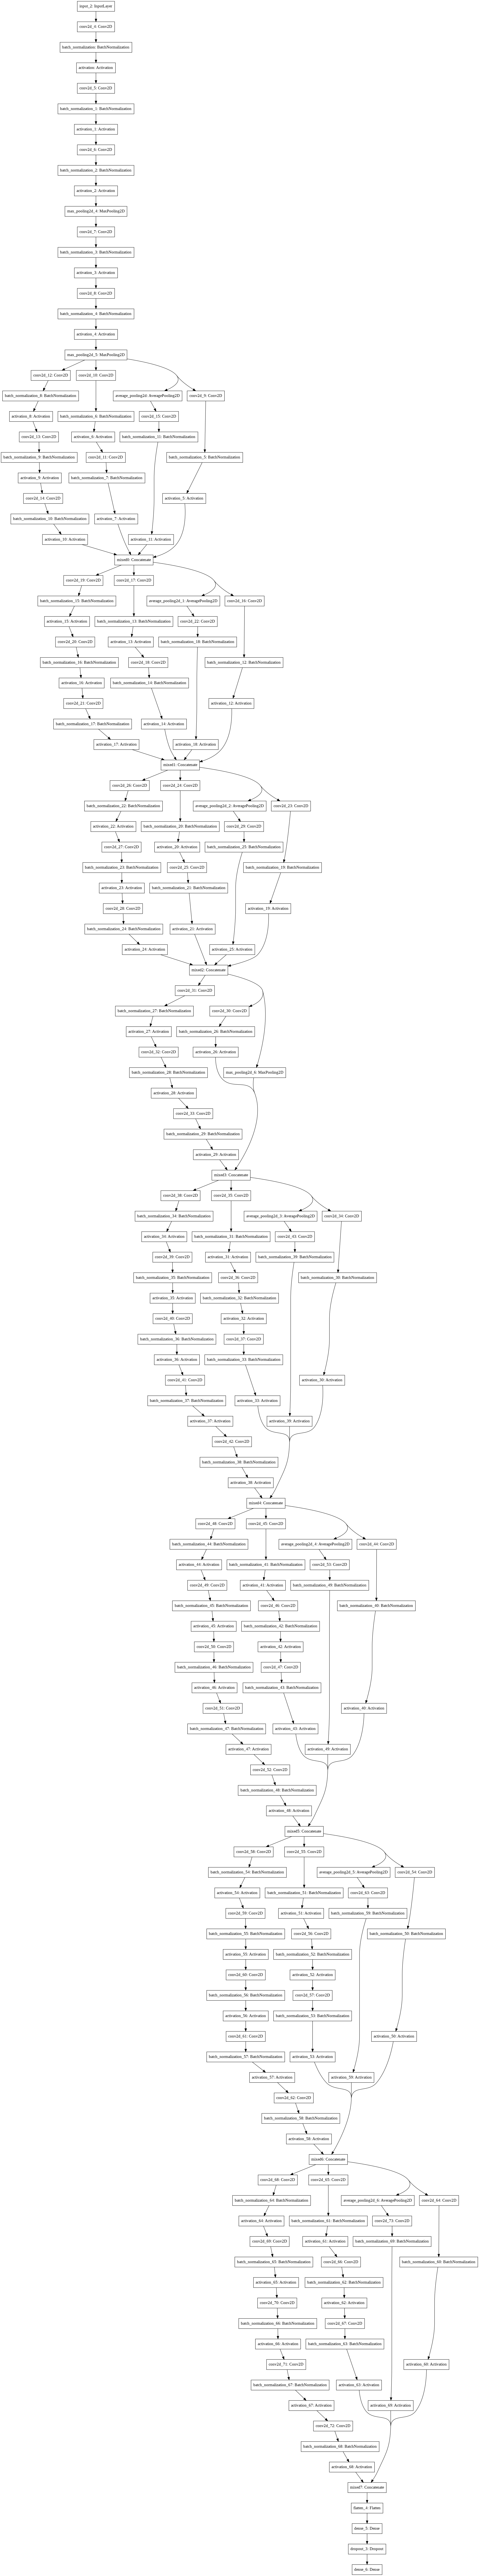

In [ ]:
tf.keras.utils.plot_model(
    model2,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Entrenamiento

In [ ]:
h2 =  model2.fit(igen['train'],
                      epochs=100,
                      verbose=1,
                      validation_data=igen['val'])

Epoch 1/100
51/51 [==============================] - 22s 362ms/step - loss: 3.7072 - accuracy: 0.2590 - val_loss: 1.1778 - val_accuracy: 0.6405
Epoch 2/100
51/51 [==============================] - 17s 333ms/step - loss: 0.9933 - accuracy: 0.6909 - val_loss: 0.9743 - val_accuracy: 0.7012
Epoch 3/100
51/51 [==============================] - 17s 334ms/step - loss: 0.6981 - accuracy: 0.7790 - val_loss: 0.7272 - val_accuracy: 0.7869
Epoch 4/100
51/51 [==============================] - 17s 328ms/step - loss: 0.5168 - accuracy: 0.8365 - val_loss: 0.6405 - val_accuracy: 0.7976
Epoch 5/100
51/51 [==============================] - 17s 331ms/step - loss: 0.3955 - accuracy: 0.8744 - val_loss: 0.5521 - val_accuracy: 0.8179
Epoch 6/100
51/51 [==============================] - 17s 334ms/step - loss: 0.3240 - accuracy: 0.8853 - val_loss: 0.5257 - val_accuracy: 0.8357
Epoch 7/100
51/51 [==============================] - 17s 335ms/step - loss: 0.3298 - accuracy: 0.8928 - val_loss: 0.6106 - val_accuracy:

In [ ]:
model2.save(raiz+'/senas2.h5')

## Testeo

In [ ]:
model2.evaluate(igen['test'])

17/17 [==============================] - 3s 157ms/step - loss: 0.3940 - accuracy: 0.9274


[0.39397579431533813, 0.9273809790611267]

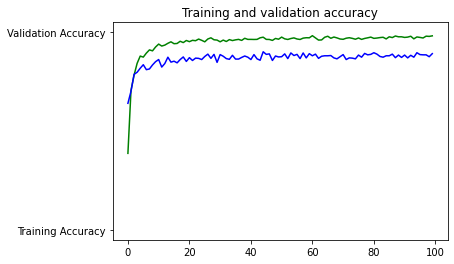

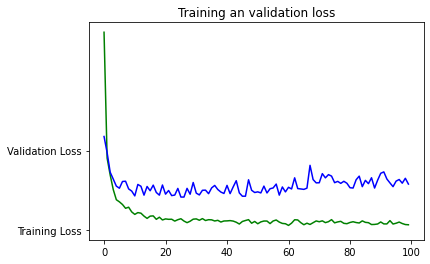

In [ ]:
ifit(h2)

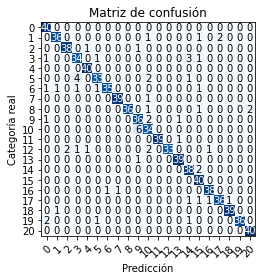

In [ ]:
cmx(igen['test'], model2)

## Casa

Saving r1.jpg to r1 (2).jpg
Saving l1.jpg to l1 (2).jpg
Saving k2.jpg to k2 (2).jpg
Saving k1.png to k1 (2).png
Saving c1.jpg to c1 (2).jpg
Saving b1.jpg to b1 (2).jpg
Saving a3.jpg to a3 (2).jpg
Saving a2.jpg to a2 (2).jpg
Saving a1.jpg to a1 (2).jpg

 
 r1.jpg


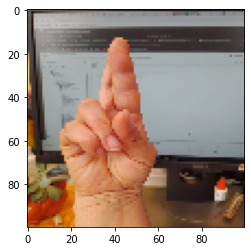

y 
 


 
 l1.jpg


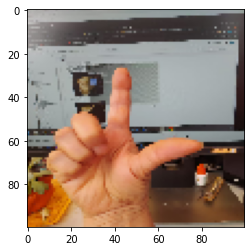

l 
 


 
 k2.jpg


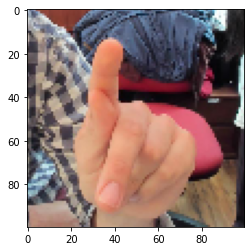

q 
 


 
 k1.png


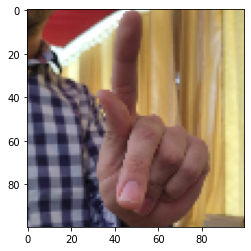

a 
 


 
 c1.jpg


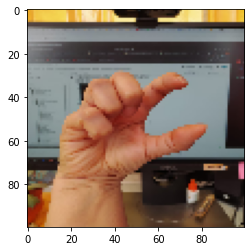

w 
 


 
 b1.jpg


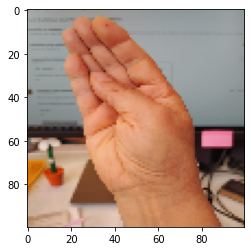

e 
 


 
 a3.jpg


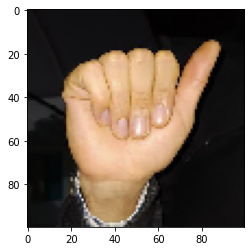

a 
 


 
 a2.jpg


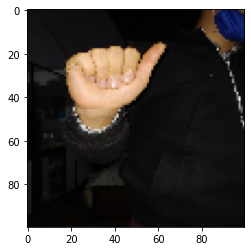

n 
 


 
 a1.jpg


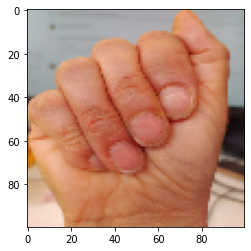

a 
 



In [ ]:
casa(model2, dim[:2], esc, labels)

# MODELO 3

## Construcción

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(len(labels), activation='softmax')(x)           

model3 = Model( iv3model.input, x) # https://keras.io/api/models/model/
model3.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
cargar = input('Cargar modelo previamente entrenado (y/N) : ').lower()

if cargar == 'y':
  model2=tf.keras.models.load_model(raiz+'/senas3.h5')
  print('Se ha cargado senas3.')
else:
  print('No se ha cargado senas3.')

Cargar modelo previamente entrenado (y/N) : n
No se ha cargado senas3.


## Resumen

In [ ]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

## Diagrama

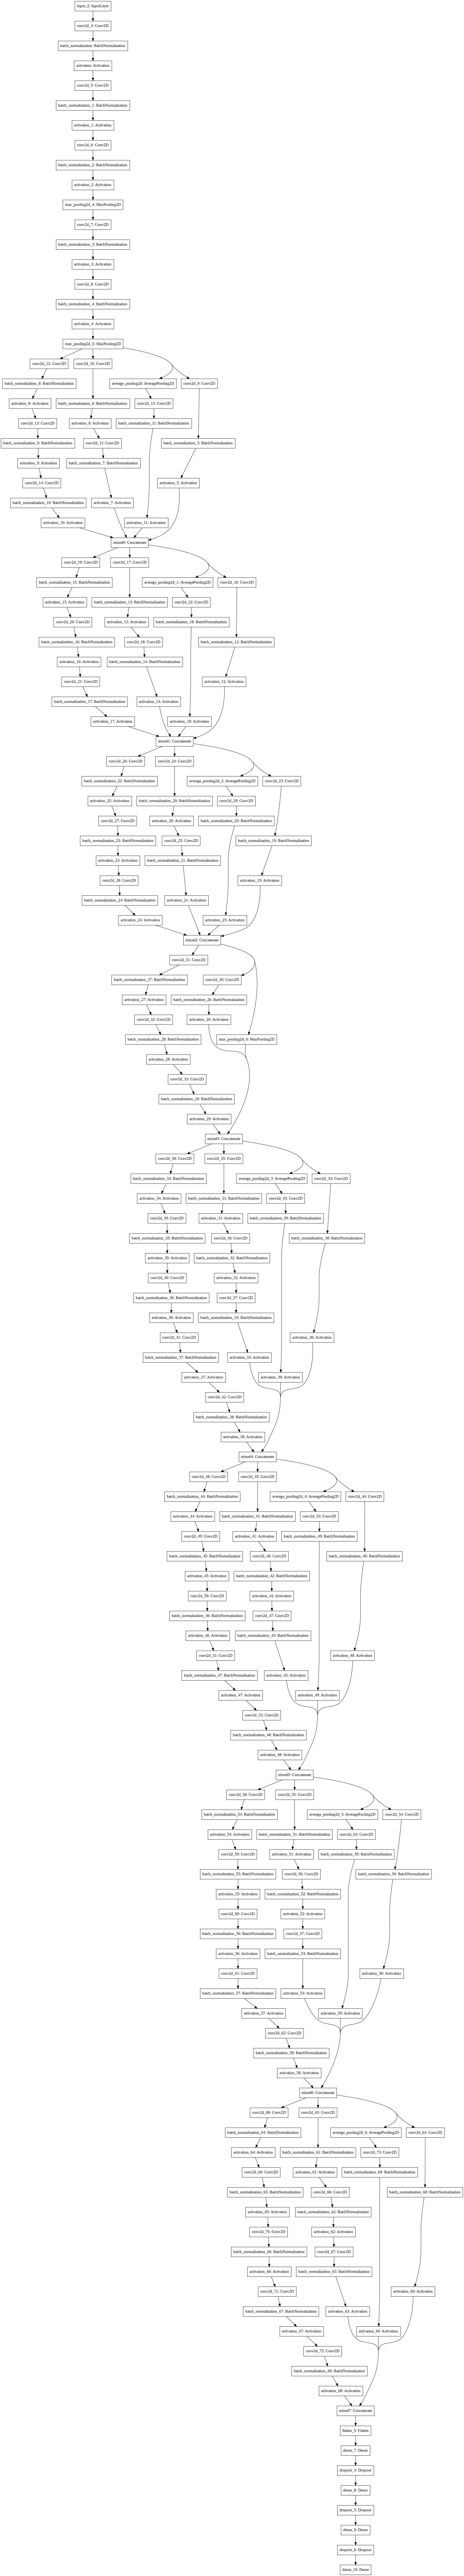

In [ ]:
tf.keras.utils.plot_model(
    model3,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Entrenamiento

In [ ]:
h3 = model3.fit(igen['train'],
                epochs=100,
                verbose=1,
                validation_data=igen['val'])

Epoch 1/100
51/51 [==============================] - 17s 332ms/step - loss: 0.1223 - accuracy: 0.9607 - val_loss: 0.5486 - val_accuracy: 0.8667
Epoch 2/100
51/51 [==============================] - 16s 323ms/step - loss: 0.1260 - accuracy: 0.9623 - val_loss: 0.5407 - val_accuracy: 0.8762
Epoch 3/100
51/51 [==============================] - 16s 326ms/step - loss: 0.1264 - accuracy: 0.9599 - val_loss: 0.4926 - val_accuracy: 0.8667
Epoch 4/100
51/51 [==============================] - 16s 323ms/step - loss: 0.1412 - accuracy: 0.9544 - val_loss: 0.4619 - val_accuracy: 0.8905
Epoch 5/100
51/51 [==============================] - 16s 324ms/step - loss: 0.1676 - accuracy: 0.9548 - val_loss: 0.5303 - val_accuracy: 0.8762
Epoch 6/100
51/51 [==============================] - 16s 325ms/step - loss: 0.1727 - accuracy: 0.9456 - val_loss: 0.4702 - val_accuracy: 0.8845
Epoch 7/100
51/51 [==============================] - 17s 329ms/step - loss: 0.1456 - accuracy: 0.9544 - val_loss: 0.4073 - val_accuracy:

In [ ]:
model3.save(raiz+'/senas3.h5')

## Testeo

In [ ]:
model3.evaluate(igen['test'])

17/17 [==============================] - 3s 154ms/step - loss: 0.3439 - accuracy: 0.9345


[0.34385886788368225, 0.9345238208770752]

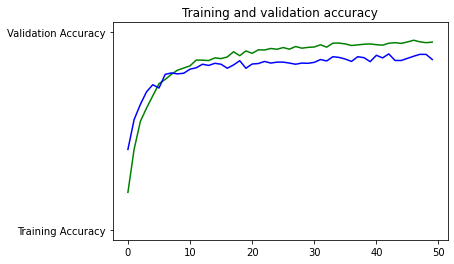

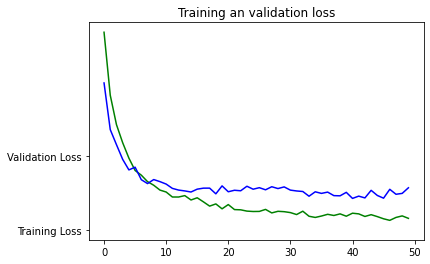

In [ ]:
ifit(h3)

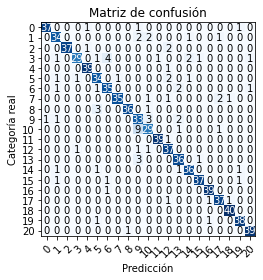

In [ ]:
cmx(igen['test'], model3)

## Casa

Saving r1.jpg to r1 (4).jpg
Saving l1.jpg to l1 (4).jpg
Saving k2.jpg to k2 (4).jpg
Saving k1.png to k1 (4).png
Saving c1.jpg to c1 (4).jpg
Saving b1.jpg to b1 (4).jpg
Saving a3.jpg to a3 (4).jpg
Saving a2.jpg to a2 (4).jpg
Saving a1.jpg to a1 (4).jpg

 
 r1.jpg


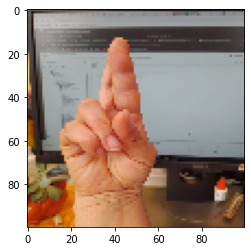

y 
 


 
 l1.jpg


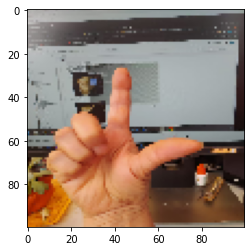

l 
 


 
 k2.jpg


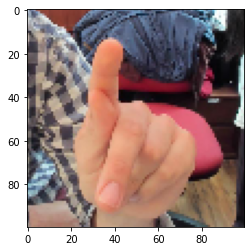

q 
 


 
 k1.png


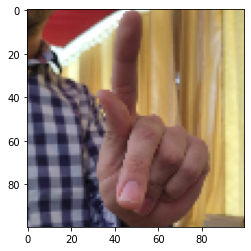

a 
 


 
 c1.jpg


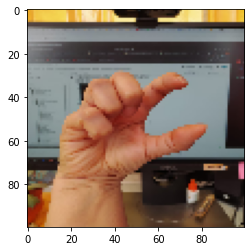

w 
 


 
 b1.jpg


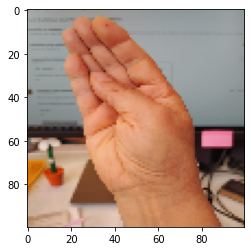

e 
 


 
 a3.jpg


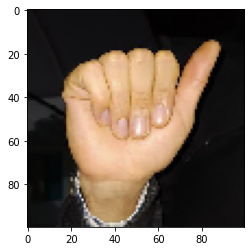

a 
 


 
 a2.jpg


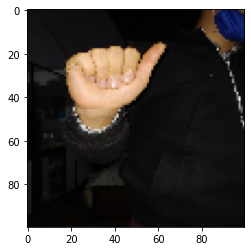

n 
 


 
 a1.jpg


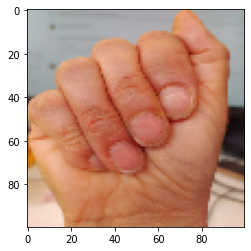

a 
 



In [ ]:
casa(model2, dim[:2], esc, labels)